In [1]:
%autosave 10

Autosaving every 10 seconds


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

colors = sns.color_palette('Dark2', n_colors=5)

from datetime import datetime
import os

FILEPATH = os.path.join(os.getcwd(), 'figs\\')

from sklearn.model_selection import GridSearchCV

## Date/time of experiment

In [4]:
print(datetime.now())

2020-10-06 09:46:16.211419


## Revised gaussian XOR generator

In [5]:
def generate_gaussian_parity(n, mean=np.array([-1, -1]), cov_scale=1, angle_params=None, k=1, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
        
    d = len(mean)
    lim = abs(mean[0])
    
    if mean[0] == -1 and mean[1] == -1:
        mean = mean + 1 / 2**k
    elif mean[0] == -2 and mean[1] == -2:
        mean = mean + 1
    
    mnt = np.random.multinomial(n, 1/(4**k) * np.ones(4**k))
    cumsum = np.cumsum(mnt)
    cumsum = np.concatenate(([0], cumsum))
    
    Y = np.zeros(n)
    X = np.zeros((n, d))
    
    for i in range(2**k):
        for j in range(2**k):
            temp = np.random.multivariate_normal(mean, cov_scale * np.eye(d), 
                                                 size=mnt[i*(2**k) + j])
            if abs(mean[0]) == 0.5:
                temp[:, 0] += i*(1/2**(k-1))
                temp[:, 1] += j*(1/2**(k-1))
                
            elif abs(mean[0]) == 1:
                temp[:, 0] += i*2
                temp[:, 1] += j*2

            # screen out values outside the boundary
            idx_oob = np.where(abs(temp) > lim)
            
            for l in idx_oob:
                
                while True:
                    temp2 = np.random.multivariate_normal(mean, cov_scale * np.eye(d), 
                                                 size=1)

                    if (abs(temp2) < lim).all():
                        temp[l] = temp2
                        break
            
            X[cumsum[i*(2**k) + j]:cumsum[i*(2**k) + j + 1]] = temp
            
            if i % 2 == j % 2:
                Y[cumsum[i*(2**k) + j]:cumsum[i*(2**k) + j + 1]] = 0
            else:
                Y[cumsum[i*(2**k) + j]:cumsum[i*(2**k) + j + 1]] = 1
                
    if d == 2:
        if angle_params is None:
            angle_params = np.random.uniform(0, 2*np.pi)
            
#         R = generate_2d_rotation(angle_params)
#         X = X @ R
        
    else:
        raise ValueError('d=%i not implemented!'%(d))
       
    return X, Y.astype(int)

In [6]:
def plot_posterior(X, y, X_post, y_post, clf, clfname, savefile=True):
    fig, axs = plt.subplots(3,2, figsize=(13,16))
    
    premax = round(X.max())
    postmax = round(X_post.max())
    prerng = (-premax,premax)
    postrng = (-postmax,postmax)
    
    X1, X2 = X[:,0], X[:,1]
    X1p, X2p = X_post[:,0], X_post[:,1]
    
    pred = clf.predict(X)
    pred_post = clf.predict(X_post)

    axs[0,0].scatter(X1, X2, c=get_colors(colors, y), s=50)

    xx, yy, zz, pp, px = plot_decision_boundaries(X, pred, clf)
    axs[0,1].pcolormesh(xx, yy, zz, cmap='copper')
    axs[0,1].scatter(X1, X2, c=get_colors(colors, pred), s=50)

    axs[1,0].scatter(X1p, X2p, c=get_colors(colors, y_post), s=50)

    xx, yy, zz, pp, px = plot_decision_boundaries(X_post, y, clf)
    axs[1,1].pcolormesh(xx, yy, zz, cmap='copper')
    axs[1,1].scatter(X1p, X2p, c=get_colors(colors, pred_post), s=50)

    xx, yy, zz, pp, px = plot_decision_boundaries(X_post, pred_post, clf, 30)
    pcm = axs[2,0].scatter(px[:,0], px[:,1], c=pp, cmap='RdBu_r', s=5)
    fig.colorbar(pcm, ax=axs[2,0])

    xx, yy, zz, pp, px = plot_decision_boundaries(X_post, pred_post, clf, 150)
    pcm = axs[2,1].scatter(px[:,0], px[:,1], c=pp, cmap='RdBu_r', s=5)
    fig.colorbar(pcm, ax=axs[2,1])

    fsize = 15

    axs[0,0].set_title('fig1: [-1, 1] simulation data', fontsize=fsize)
    axs[0,1].set_title('fig2: ' + clfname +' trained on [-1, 1]', fontsize=fsize)
    axs[1,0].set_title('fig3: [-2, 2] simulation data', fontsize=fsize)
    axs[1,1].set_title('fig4: ' + clfname +' feature prediction on [-2, 2] simulation data', fontsize=fsize)
    axs[2,0].set_title('fig5: ' + clfname +' posterior (901 masses, [-2, 2])', fontsize=fsize)
    axs[2,1].set_title('fig6: ' + clfname +' posterior (22501 masses, [-2, 2])', fontsize=fsize)

    axs[0,0].set_xlim(np.multiply(prerng, 1.1))
    axs[0,0].set_ylim(np.multiply(prerng, 1.1))
    axs[0,1].set_xlim(np.multiply(prerng, 1.1))
    axs[0,1].set_ylim(np.multiply(prerng, 1.1))
    axs[1,0].set_xlim(np.multiply(postrng, 1.1))
    axs[1,0].set_ylim(np.multiply(postrng, 1.1))
    axs[1,1].set_xlim(np.multiply(postrng, 1.1))
    axs[1,1].set_ylim(np.multiply(postrng, 1.1))
    axs[2,0].set_xlim(postrng)
    axs[2,0].set_ylim(postrng)
    axs[2,1].set_xlim(postrng)
    axs[2,1].set_ylim(postrng)

    if not os.path.isdir(FILEPATH):
        os.makedirs(FILEPATH)
    
    if savefile:
        plt.savefig('figs/' + clfname + '.png')
    
    plt.tight_layout()
    plt.show()

In [7]:
def generate_spirals(N, D=2, K=5, noise = 0.5, acorn = None, density=0.3, rng = 1):

    #N number of poinst per class
    #D number of features, 
    #K number of classes
    X = []
    Y = []
    if acorn is not None:
        np.random.seed(acorn)
    
    if K == 2:
        turns = 2
    elif K==3:
        turns = 2.5
    elif K==5:
        turns = 3.5
    elif K==7:
        turns = 4.5
    else:
        print ("sorry, can't currently surpport %s classes " %K)
        return
    
    mvt = np.random.multinomial(N, 1/K * np.ones(K))
    
    if K == 2:
        r = np.random.uniform(0, rng, size=int(N/K))
        r = np.sort(r)
        t = np.linspace(0,  np.pi* 4 * turns/K, int(N/K)) + noise * np.random.normal(0, density, int(N/K))
        dx = r * np.cos(t)
        dy = r * np.sin(t)

        X.append(np.vstack([dx, dy]).T)
        X.append(np.vstack([-dx, -dy]).T)
        Y += [0] * int(N/K) 
        Y += [1] * int(N/K)
    else:    
        for j in range(1, K+1):
            r = np.linspace(0.01, rng, int(mvt[j-1]))
            t = np.linspace((j-1) * np.pi *4 *turns/K,  j* np.pi * 4* turns/K, int(mvt[j-1])) + noise * np.random.normal(0, density, int(mvt[j-1]))
            dx = r * np.cos(t)
            dy = r * np.sin(t)

            dd = np.vstack([dx, dy]).T        
            X.append(dd)
            #label
            Y += [j-1] * int(mvt[j-1])
    return np.vstack(X), np.array(Y).astype(int)

In [8]:
def get_colors(colors, inds):
    c = [colors[i] for i in inds]
    return c

In [9]:
def plot_posterior(X, y, X_post, y_post, clf, clfname, savefile=True):
    fig, axs = plt.subplots(3,2, figsize=(13,16))
    
    premax = round(X.max())
    postmax = round(X_post.max())
    prerng = (-premax,premax)
    postrng = (-postmax,postmax)
    
    X1, X2 = X[:,0], X[:,1]
    X1p, X2p = X_post[:,0], X_post[:,1]
    
    pred = clf.predict(X)
    pred_post = clf.predict(X_post)

    axs[0,0].scatter(X1, X2, c=get_colors(colors, y), s=50)

    xx, yy, zz, pp, px = plot_decision_boundaries(X, pred, clf)
    axs[0,1].pcolormesh(xx, yy, zz, cmap='copper')
    axs[0,1].scatter(X1, X2, c=get_colors(colors, pred), s=50)

    axs[1,0].scatter(X1p, X2p, c=get_colors(colors, y_post), s=50)

    xx, yy, zz, pp, px = plot_decision_boundaries(X_post, y, clf)
    axs[1,1].pcolormesh(xx, yy, zz, cmap='copper')
    axs[1,1].scatter(X1p, X2p, c=get_colors(colors, pred_post), s=50)

    xx, yy, zz, pp, px = plot_decision_boundaries(X_post, pred_post, clf, 30)
    pcm = axs[2,0].scatter(px[:,0], px[:,1], c=pp, cmap='RdBu_r', s=5)
    fig.colorbar(pcm, ax=axs[2,0])

    xx, yy, zz, pp, px = plot_decision_boundaries(X_post, pred_post, clf, 150)
    pcm = axs[2,1].scatter(px[:,0], px[:,1], c=pp, cmap='RdBu_r', s=5)
    fig.colorbar(pcm, ax=axs[2,1])

    fsize = 15

    axs[0,0].set_title('fig1: [-1, 1] simulation data', fontsize=fsize)
    axs[0,1].set_title('fig2: ' + clfname +' trained on [-1, 1]', fontsize=fsize)
    axs[1,0].set_title('fig3: [-2, 2] simulation data', fontsize=fsize)
    axs[1,1].set_title('fig4: ' + clfname +' feature prediction on [-2, 2] simulation data', fontsize=fsize)
    axs[2,0].set_title('fig5: ' + clfname +' posterior (901 masses, [-2, 2])', fontsize=fsize)
    axs[2,1].set_title('fig6: ' + clfname +' posterior (22501 masses, [-2, 2])', fontsize=fsize)

    axs[0,0].set_xlim(np.multiply(prerng, 1.1))
    axs[0,0].set_ylim(np.multiply(prerng, 1.1))
    axs[0,1].set_xlim(np.multiply(prerng, 1.1))
    axs[0,1].set_ylim(np.multiply(prerng, 1.1))
    axs[1,0].set_xlim(np.multiply(postrng, 1.1))
    axs[1,0].set_ylim(np.multiply(postrng, 1.1))
    axs[1,1].set_xlim(np.multiply(postrng, 1.1))
    axs[1,1].set_ylim(np.multiply(postrng, 1.1))
    axs[2,0].set_xlim(postrng)
    axs[2,0].set_ylim(postrng)
    axs[2,1].set_xlim(postrng)
    axs[2,1].set_ylim(postrng)

    if not os.path.isdir(FILEPATH):
        os.makedirs(FILEPATH)
    
    if savefile:
        plt.savefig('figs/' + clfname + '.png')
    
    plt.tight_layout()
    plt.show()

In [10]:
def plot_decision_boundaries(X, y, clf, lim=2, mass_res=1):
    
    h = .02  # step size in the mesh
    
    offset = 0
    
    x_min, x_max = X[:, 0].min()-offset, X[:, 0].max()+offset
    y_min, y_max = X[:, 1].min()-offset, X[:, 1].max()+offset
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    zz = np.c_[xx.ravel(), yy.ravel()]
    
    pX = np.array([[0,0]])
    
    for i in np.linspace(-2,2,mass_res):
        temp = np.c_[np.linspace(i,i,mass_res).ravel(), np.linspace(-2,2,mass_res).ravel()]
        pX = np.concatenate([pX, temp], axis=0)
    
    p = clf.predict_proba(zz)
    new_p = p[:,0]# - p[:,1]
    
    Z = clf.predict(zz)    
    Z = Z.reshape(xx.shape)
    
    return xx, yy, Z, new_p, zz

In [11]:
def pdf(x):
    
    # Generates true XOR posterior
    
    mu01 = np.array([-0.5,0.5])
    mu02 = np.array([0.5,-0.5])
    mu11 = np.array([0.5,0.5])
    mu12 = np.array([-0.5,-0.5])
    cov = 0.25 * np.eye(2)
    inv_cov = np.linalg.inv(cov) 

    p0 = (
        np.exp(-(x - mu01)@inv_cov@(x-mu01).T) 
        + np.exp(-(x - mu02)@inv_cov@(x-mu02).T)
    )/(2*np.pi*np.sqrt(np.linalg.det(cov)))

    p1 = (
        np.exp(-(x - mu11)@inv_cov@(x-mu11).T) 
        + np.exp(-(x - mu12)@inv_cov@(x-mu12).T)
    )/(2*np.pi*np.sqrt(np.linalg.det(cov)))

    return p0/(p0+p1)

In [12]:
# testx, testy = np.meshgrid(np.linspace(-2,2,100),
#             np.linspace(-2,2,100))

# zz = np.c_[testx.ravel(), testy.ravel()]

# # np.meshgrid([2],[2])[0]
# # testx#.shape
# testx = [[0,1],[0,1],[0,3],[1,3]]
# # # testx = [[0,1,3,4],[1,2,4]]
# # len(testx)
# # zp = np.shape(zz)

# sns.heatmap(zp)

## Generating gaussian data

In [13]:
gausX, gausY = generate_gaussian_parity(750, mean=np.array([-1,-1]), cov_scale=0.1, angle_params=np.pi)
new_gausX, new_gausY = generate_gaussian_parity(750, mean=np.array([-2,-2]), cov_scale=0.4, angle_params=np.pi)

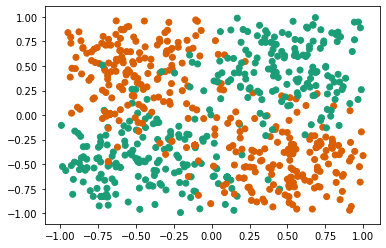

In [14]:
plt.scatter(gausX[:,0],gausX[:,1], c=get_colors(colors, gausY))

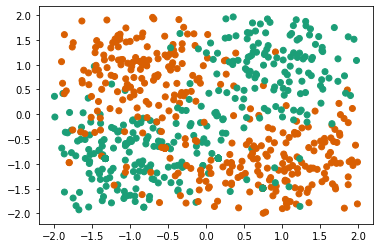

In [15]:
plt.scatter(new_gausX[:,0],new_gausX[:,1], c=get_colors(colors, gausY))

## Generating spiral data

In [16]:
spirX, spirY = generate_spirals(750, 0, 2, noise = 2.5, rng=1)
new_spirX, new_spirY = generate_spirals(750, 0, 2, noise = 2.5, rng=2)

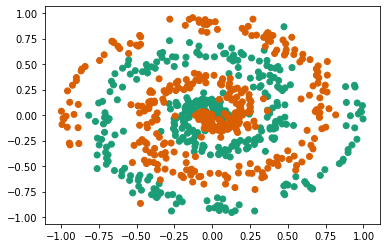

In [17]:
plt.scatter(spirX[:,0],spirX[:,1], c=get_colors(colors, spirY))

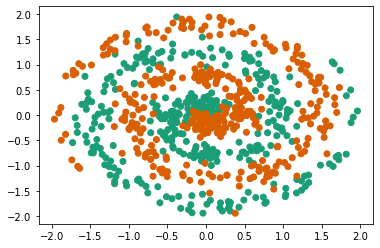

In [18]:
plt.scatter(new_spirX[:,0],new_spirX[:,1], c=get_colors(colors, spirY))

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap

from sklearn import svm

import xgboost as xgb

from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestClassifier

## training algorithms

In [20]:
def train_algo(X, y, newX, newy, dset, enable=[1,1,1,1,1,1], savefile=True):
    
    def tune_param(clf, param, name):
        
        model=GridSearchCV(clf, param_grid=param, return_train_score=True, cv=20)
        model.fit(X, y)
        
        print(name + " INFO:")
        print("Best hyper paramters:",model.best_params_)
        print("Best accuracy value: ",model.best_score_ )
        
        clf.set_params(**model.best_params_)
        clf.fit(X, y)
        print("prediction score: ", clf.score(newX,newy))
        print(clf)
        
        plot_posterior(X, y, newX, newy, clf, name, savefile)
    
    prefix = ['XOR_', 'spiral_']
    mod_n = ['KNN', 'SVC', 'nuSVC', 'XGBoost', 'overparam-MLP', 'RF']
    mods = [prefix[dset] + i for i in mod_n]
    
    ##### KNN #####
    
    if enable[0] == 1:
        tuned_param=[{'n_neighbors':[3,5,7], 'leaf_size':range(10,100,10)},
                     {'n_neighbors':[7]}]
        tune_param(KNeighborsClassifier(), tuned_param[dset], mods[0])
    
    ##### SVC #####
    
    if enable[1] == 1:
        tuned_param=[{'gamma':['auto'], 'probability':[True]},
                     {'C':np.linspace(1,10,10), 'probability':[True]}]
        tune_param(svm.SVC(), tuned_param[dset], mods[1])
                   
    ##### nuSVC #####
    
    if enable[2] == 1:
        tuned_param=[{'gamma':['auto'], 'probability':[True]},
                     {'probability':[True]}]
        tune_param(svm.NuSVC(), tuned_param[dset], mods[2])

    ##### xgbooster #####
    
    if enable[3] == 1:
        tuned_param=[ {'n_jobs':[-1], 'learning_rate':np.linspace(0,1,30), 
                     'gamma': np.linspace(0,1,10), 'objective':['binary:logistic']},
                    {'n_jobs':[-1], 'gamma': np.linspace(0,1,10)}]
        xor_xgb = tune_param(xgb.XGBClassifier(objective='binary:logistic'), 
                             tuned_param[dset], mods[3])
    
    #### mlp #####
    
    if enable[4] == 1:
        tuned_param=[{'alpha':[0], 'max_iter':[7000], 'hidden_layer_sizes':[100], 'learning_rate_init':[0.0001]},
                    {'alpha':[0], 'max_iter':[10000], 'activation':['logistic', 'relu'], 'learning_rate_init':[0.0001], 'solver': ['lbfgs']}]
        tune_param(MLPClassifier(), tuned_param[dset], mods[4])

    #### RF #####
    
    if enable[5] == 1:
        tuned_param=[{'max_depth':range(1,11),'n_estimators':range(1,11)},
                    {'max_depth':range(10,20,2),'n_estimators':range(7,11)}]
        tune_param(RandomForestClassifier(n_jobs=-1), 
                   tuned_param[dset], mods[5])
   

In [21]:
def plot_posterior(X, y, X_post, y_post, clf, clfname, savefile=True):
    fig, axs = plt.subplots(3,2, figsize=(13,16))
    
    premax = round(X.max())
    postmax = round(X_post.max())
    prerng = (-premax,premax)
    postrng = (-postmax,postmax)
    
    X1, X2 = X[:,0], X[:,1]
    X1p, X2p = X_post[:,0], X_post[:,1]
    
    pred = clf.predict(X)
    pred_post = clf.predict(X_post)

    axs[0,0].scatter(X1, X2, c=get_colors(colors, y), s=50)

#     xx, yy, zz, pp, px = plot_decision_boundaries(X, pred, clf)
#     axs[0,1].pcolormesh(xx, yy, zz, cmap='copper')
#     axs[0,1].scatter(X1, X2, c=get_colors(colors, pred), s=50)

#     axs[1,0].scatter(X1p, X2p, c=get_colors(colors, y_post), s=50)

#     xx, yy, zz, pp, px = plot_decision_boundaries(X_post, y, clf)
#     axs[1,1].pcolormesh(xx, yy, zz, cmap='copper')
#     axs[1,1].scatter(X1p, X2p, c=get_colors(colors, pred_post), s=50)

#     xx, yy, zz, pp, px = plot_decision_boundaries(X_post, pred_post, clf, 30)
#     pcm = axs[2,0].scatter(px[:,0], px[:,1], c=pp, cmap='RdBu_r', s=5)
#     fig.colorbar(pcm, ax=axs[2,0])

    xx, yy, zz, pp, px = plot_decision_boundaries(X, y, clf, 150)
    pcm = axs[0,1].scatter(px[:,0], px[:,1], c=pp, cmap='RdBu_r', s=5)
    fig.colorbar(pcm, ax=axs[0,1])

    pp = pdf(px)
#     xx, yy, zz, pp, px = plot_decision_boundaries(X, y, clf, 150)
    pcm = axs[1,0].scatter(px[:,0], px[:,1], c=pp, cmap='RdBu_r', s=5)
    fig.colorbar(pcm, ax=axs[1,0])
    
    fsize = 15

    axs[0,0].set_title('fig1: [-1, 1]\u00b2 simulation data', fontsize=fsize)
    axs[0,1].set_title('fig2: ' + clfname +' trained on [-2, 2]\u00b2', fontsize=fsize)
    axs[1,0].set_title('fig3: [-2, 2]\u00b2 true posterior', fontsize=fsize)
#     axs[1,1].set_title('fig4: ' + clfname +' feature prediction on [-2, 2] simulation data', fontsize=fsize)
#     axs[2,0].set_title('fig5: ' + clfname +' posterior (901 masses, [-2, 2])', fontsize=fsize)
#     axs[2,1].set_title('fig6: ' + clfname +' posterior (22501 masses, [-2, 2])', fontsize=fsize)

    axs[0,0].set_xlim(np.multiply(postrng, 1))
    axs[0,0].set_ylim(np.multiply(postrng, 1))
#     axs[0,1].set_xlim(np.multiply(prerng, 1.1))
#     axs[0,1].set_ylim(np.multiply(prerng, 1.1))
#     axs[1,0].set_xlim(np.multiply(postrng, 1.1))
#     axs[1,0].set_ylim(np.multiply(postrng, 1.1))
    axs[0,1].set_xlim(np.multiply(postrng, 1))
    axs[0,1].set_ylim(np.multiply(postrng, 1))
#     axs[2,0].set_xlim(postrng)
#     axs[2,0].set_ylim(postrng)
#     axs[2,1].set_xlim(postrng)
#     axs[2,1].set_ylim(postrng)

    if not os.path.isdir(FILEPATH):
        os.makedirs(FILEPATH)
    
    if savefile:
        plt.savefig('figs/' + clfname + '.png')
    
    plt.tight_layout()
    plt.show()

## running experiments for single algorithm

XOR_SVC INFO:
Best hyper paramters: {'gamma': 'auto', 'probability': True}
Best accuracy value:  0.8347439544807965
prediction score:  0.8013333333333333
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


ValueError: 'c' argument has 10000 elements, which is not acceptable for use with 'x' with size 10000, 'y' with size 10000.

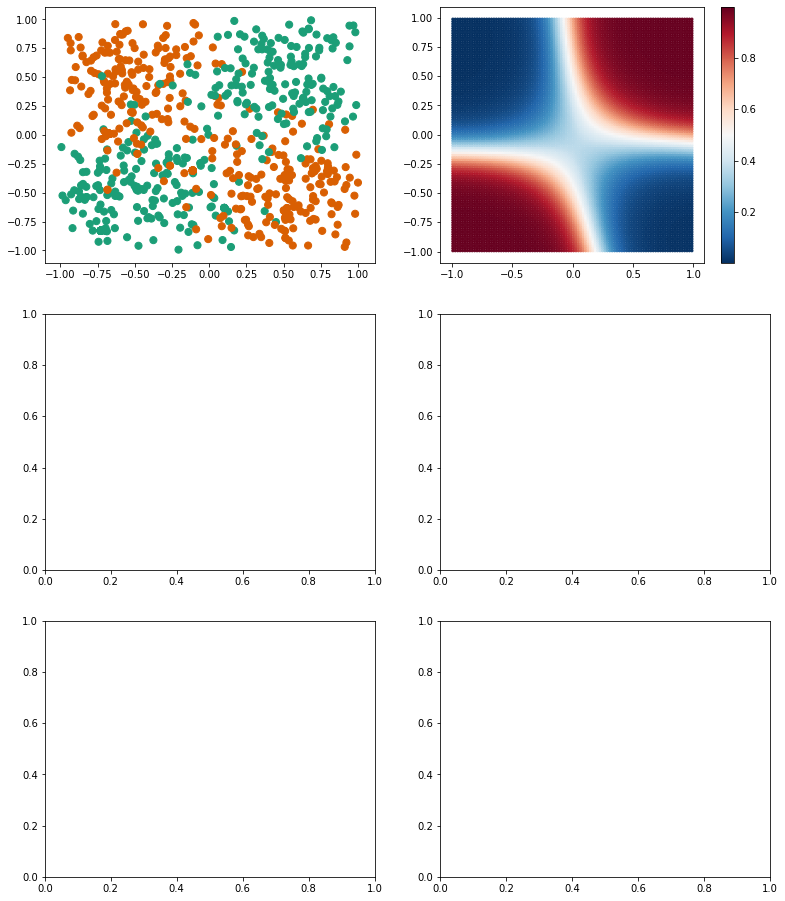

In [22]:
# enable = [1,1,1,1,1,1]
enable = [0,1,0,0,0,0]

train_algo(gausX, gausY, new_gausX, new_gausY, 0, enable, savefile=False)

## running the complete XOR experiments

XOR_KNN INFO:
Best hyper paramters: {'leaf_size': 10, 'n_neighbors': 7}
Best accuracy value:  0.8639046941678521
prediction score:  0.7933333333333333
KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')


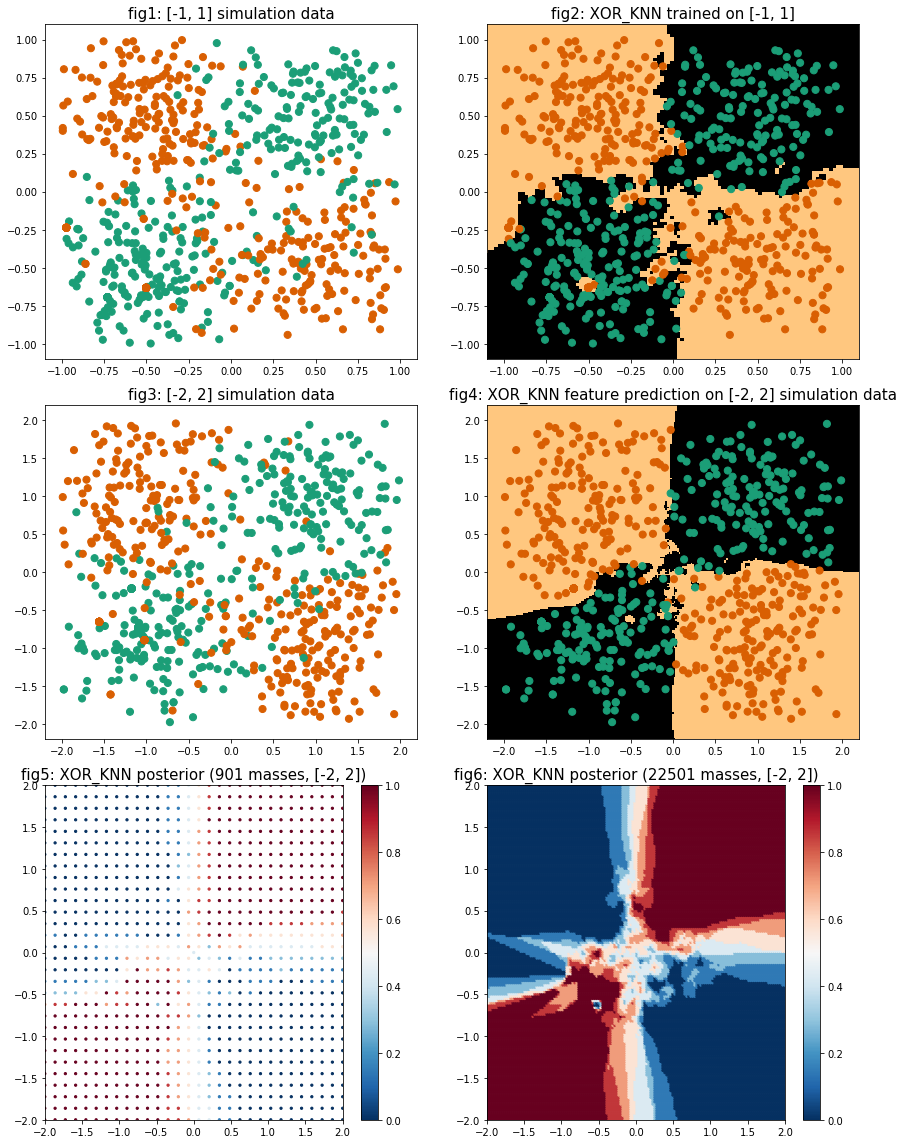

XOR_SVC INFO:
Best hyper paramters: {'gamma': 'auto', 'probability': True}
Best accuracy value:  0.8316856330014225
prediction score:  0.7706666666666667
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


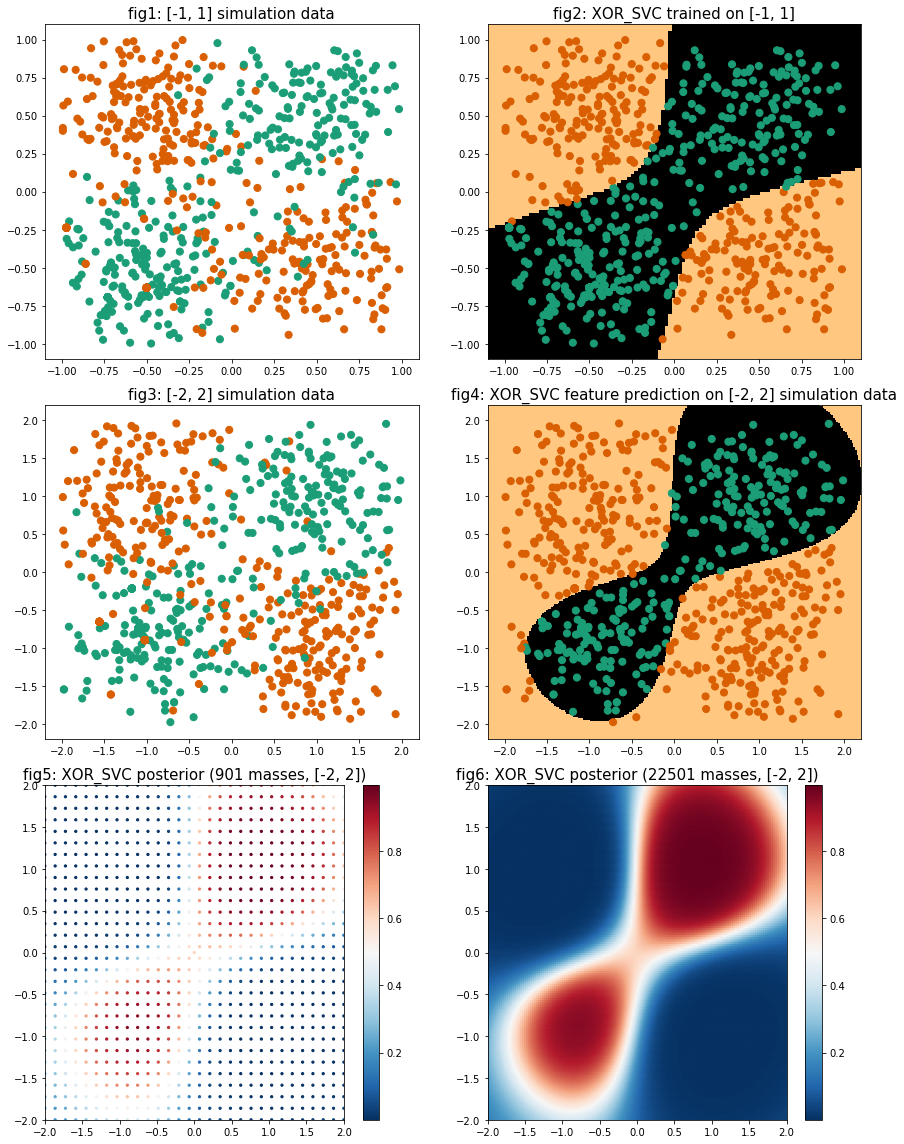

XOR_nuSVC INFO:
Best hyper paramters: {'gamma': 'auto', 'probability': True}
Best accuracy value:  0.8316500711237553
prediction score:  0.788
NuSVC(break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.5, probability=True, random_state=None, shrinking=True,
      tol=0.001, verbose=False)


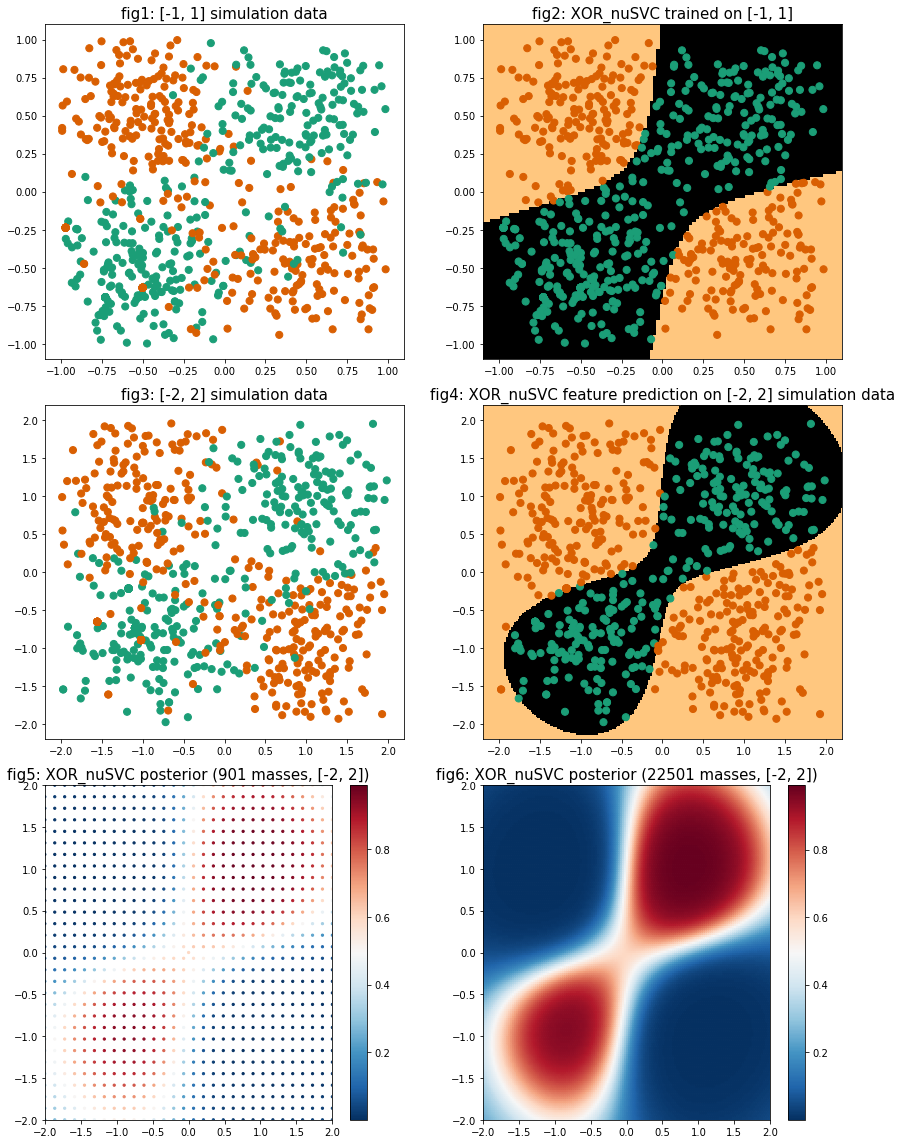

XOR_XGBoost INFO:
Best hyper paramters: {'gamma': 1.0, 'learning_rate': 0.5517241379310345, 'n_jobs': -1, 'objective': 'binary:logistic'}
Best accuracy value:  0.8730796586059743
prediction score:  0.8106666666666666
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1.0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.5517241379310345, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)


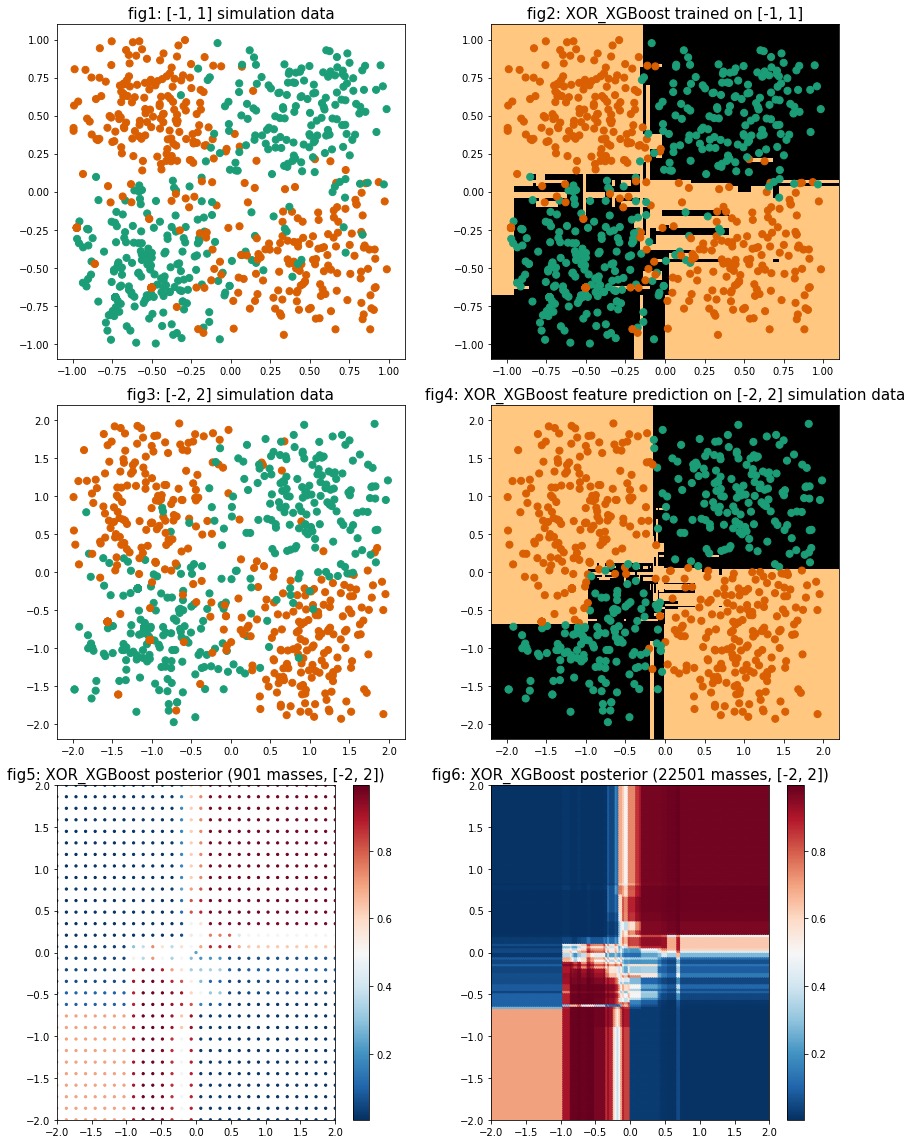

XOR_overparam-MLP INFO:
Best hyper paramters: {'alpha': 0, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.0001, 'max_iter': 7000}
Best accuracy value:  0.830547652916074
prediction score:  0.7813333333333333
MLPClassifier(activation='relu', alpha=0, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=100, learning_rate='constant',
              learning_rate_init=0.0001, max_fun=15000, max_iter=7000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


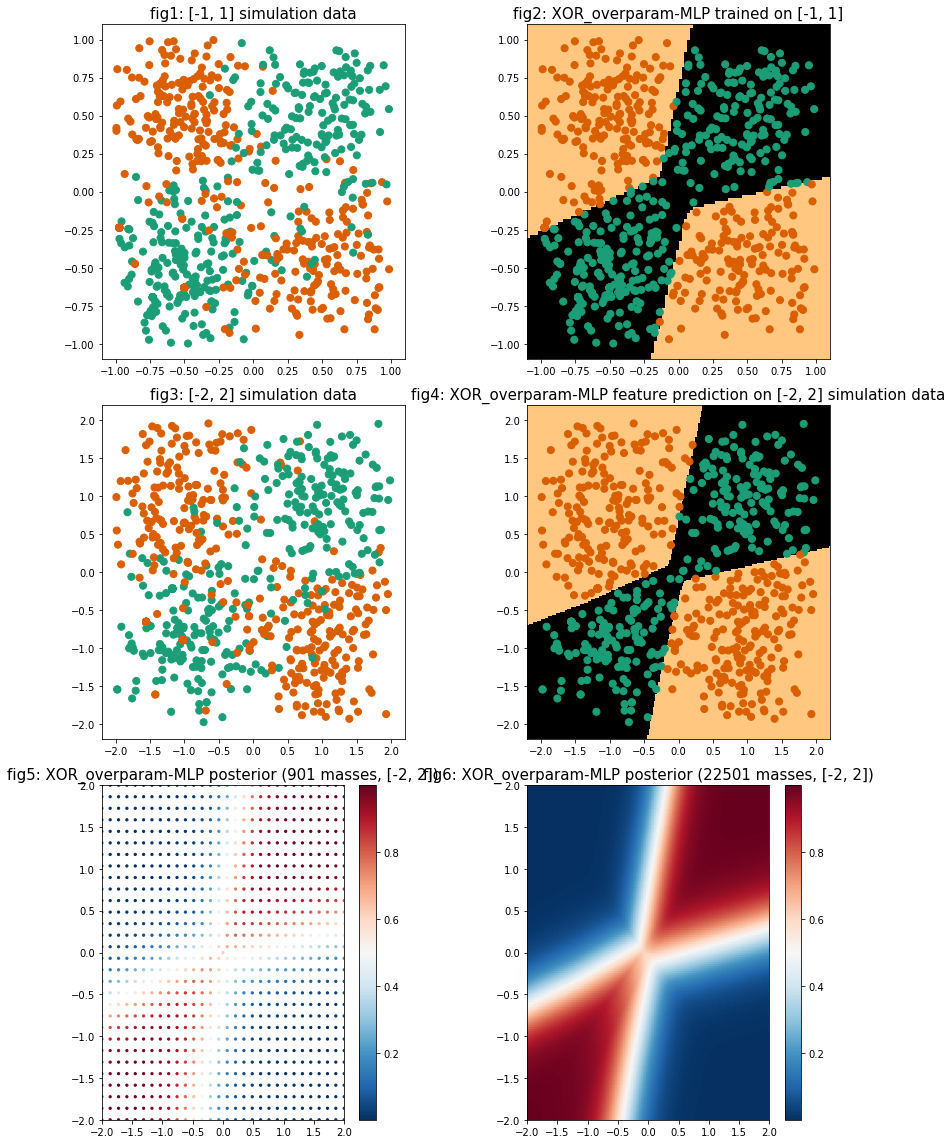

XOR_RF INFO:
Best hyper paramters: {'max_depth': 6, 'n_estimators': 9}
Best accuracy value:  0.8839260312944524
prediction score:  0.7453333333333333
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


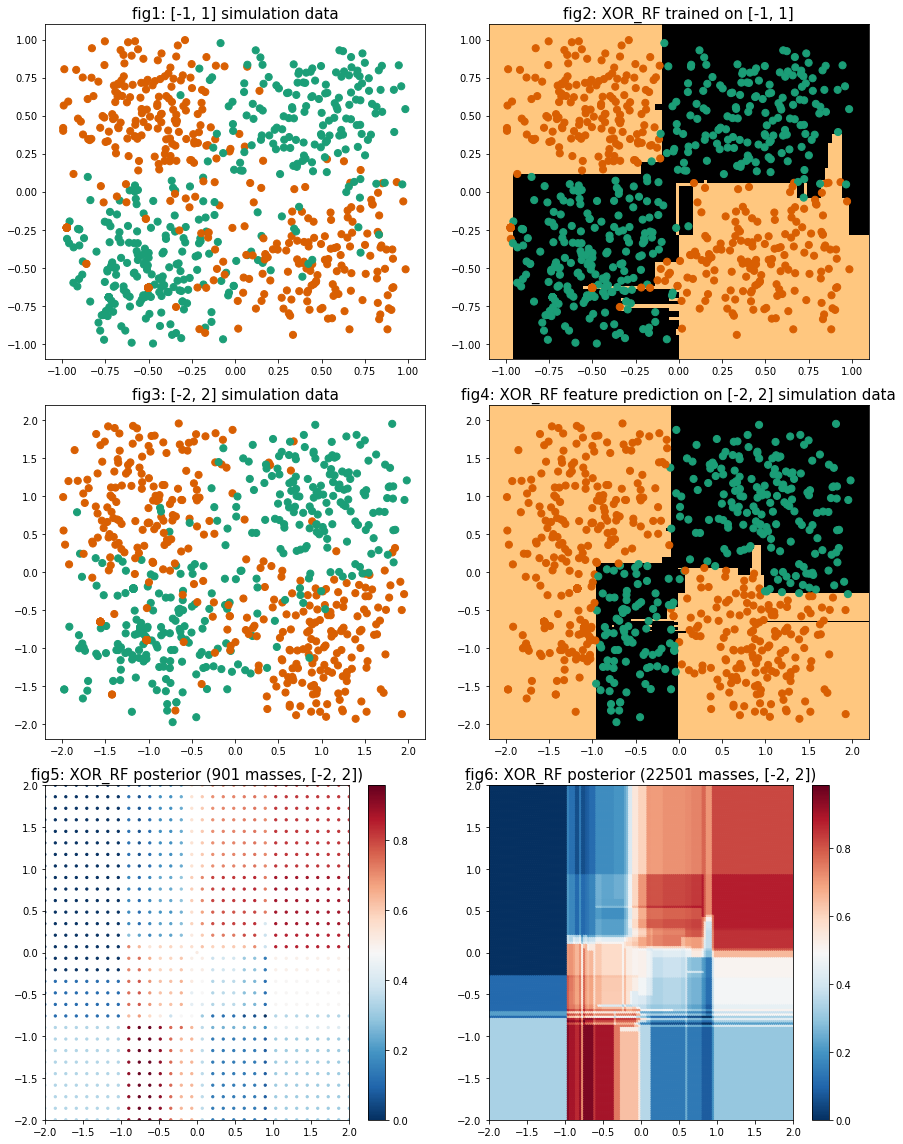

In [17]:
# enable = [0,0,0,0,0,1]
enable = [1,1,1,1,1,1]

train_algo(gausX, gausY, new_gausX, new_gausY, 0, enable)

## running the complete spiral experiments

spiral_KNN INFO:
Best hyper paramters: {'n_neighbors': 7}
Best accuracy value:  0.864153627311522
prediction score:  0.456
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')


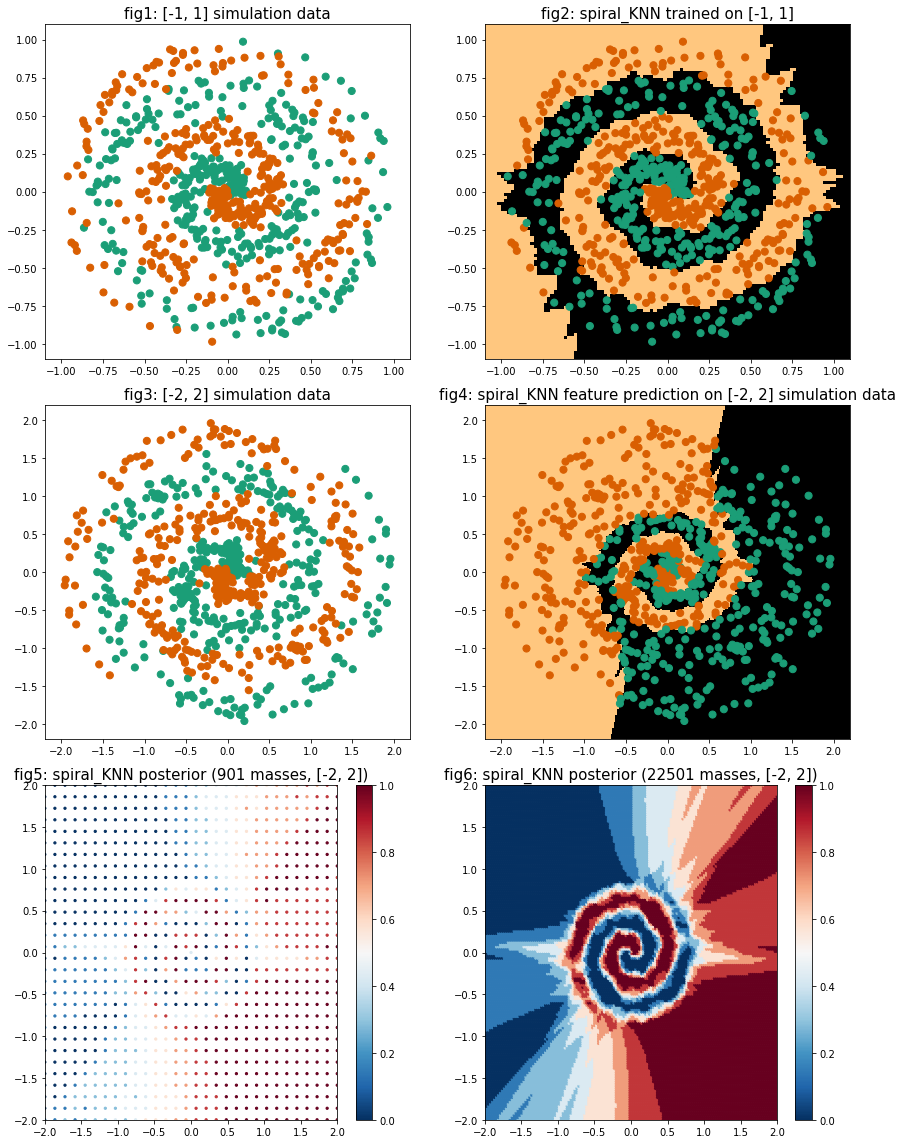

spiral_SVC INFO:
Best hyper paramters: {'C': 1.0, 'probability': True}
Best accuracy value:  0.4384068278805122
prediction score:  0.5066666666666667
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


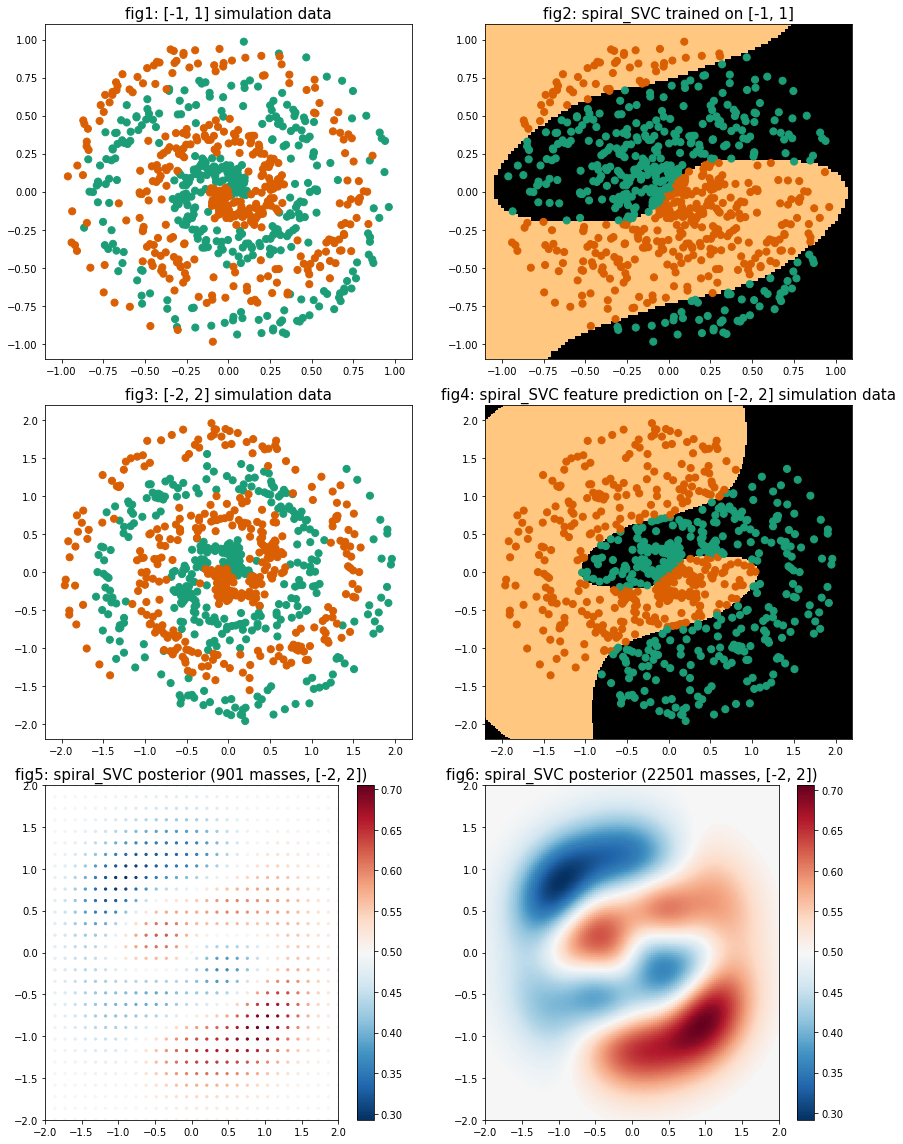

spiral_nuSVC INFO:
Best hyper paramters: {'probability': True}
Best accuracy value:  0.7354551920341393
prediction score:  0.37066666666666664
NuSVC(break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, nu=0.5, probability=True, random_state=None, shrinking=True,
      tol=0.001, verbose=False)


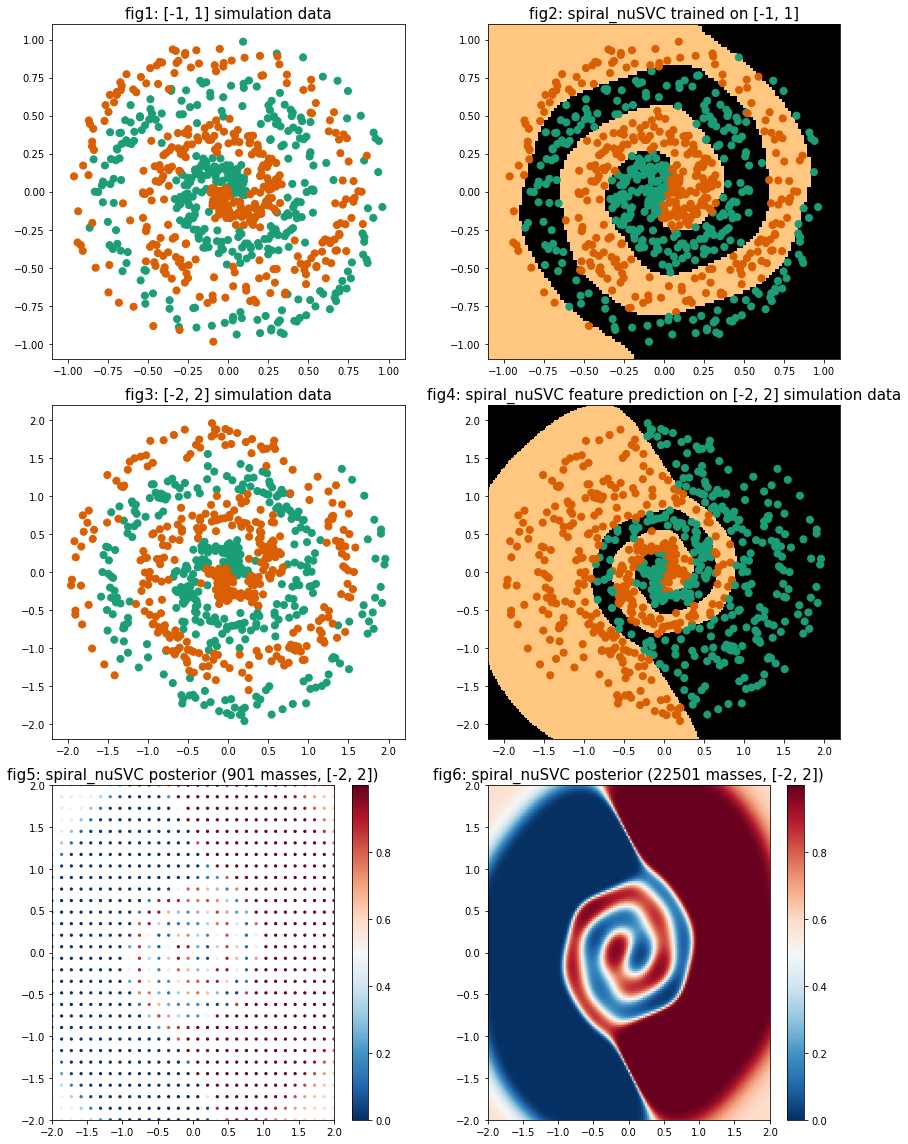

spiral_XGBoost INFO:
Best hyper paramters: {'gamma': 0.3333333333333333, 'n_jobs': -1}
Best accuracy value:  0.8421052631578947
prediction score:  0.4266666666666667
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.3333333333333333,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)


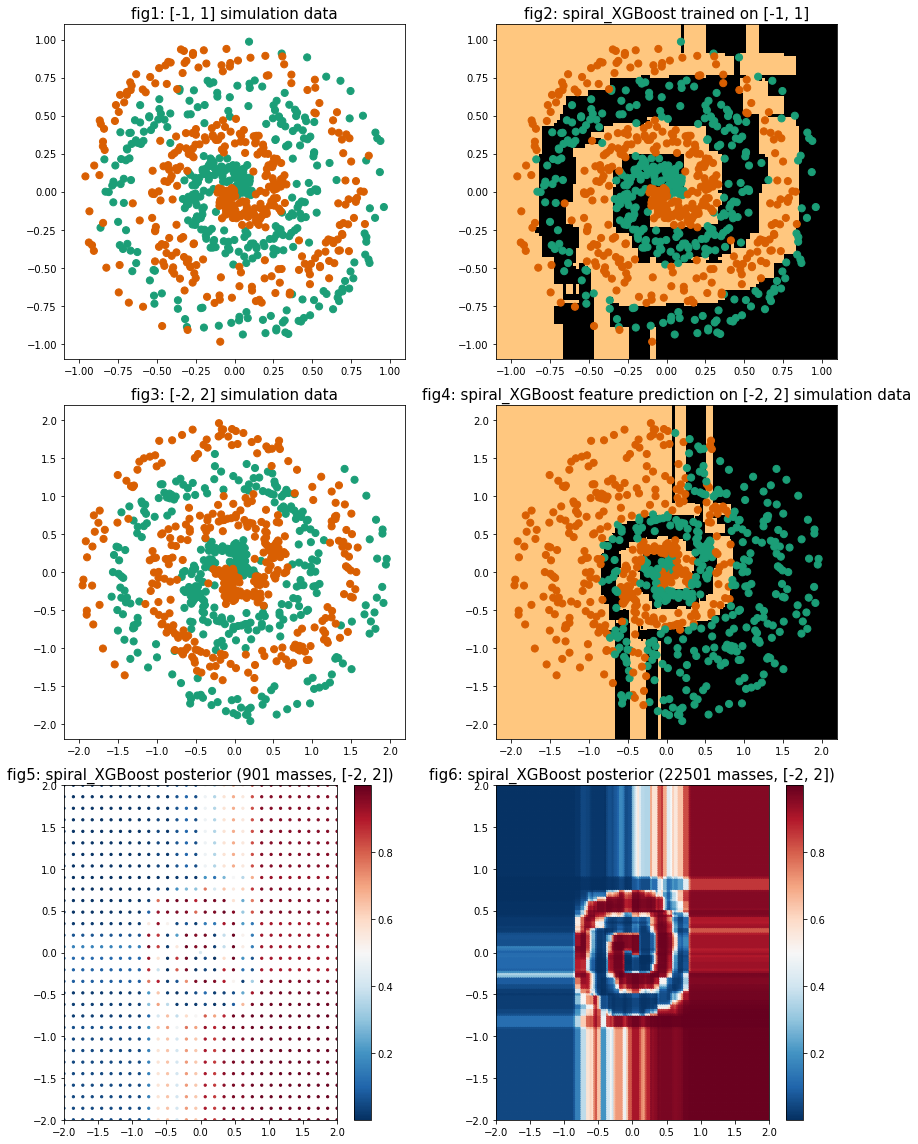

spiral_overparam-MLP INFO:
Best hyper paramters: {'activation': 'relu', 'alpha': 0, 'learning_rate_init': 0.0001, 'max_iter': 10000, 'solver': 'lbfgs'}
Best accuracy value:  0.8700924608819346
prediction score:  0.48133333333333334
MLPClassifier(activation='relu', alpha=0, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.0001, max_fun=15000, max_iter=10000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


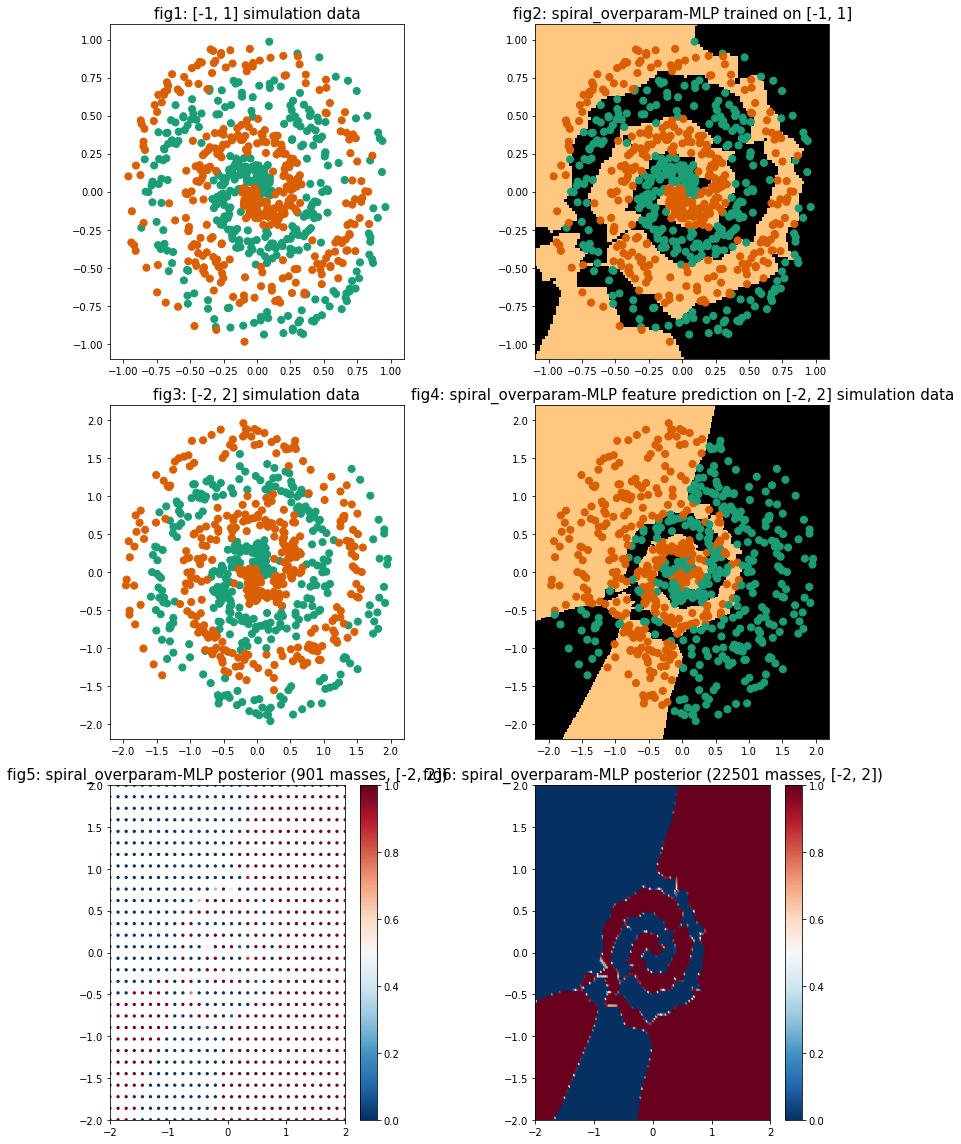

spiral_RF INFO:
Best hyper paramters: {'max_depth': 14, 'n_estimators': 10}
Best accuracy value:  0.8513157894736842
prediction score:  0.4653333333333333
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=14, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


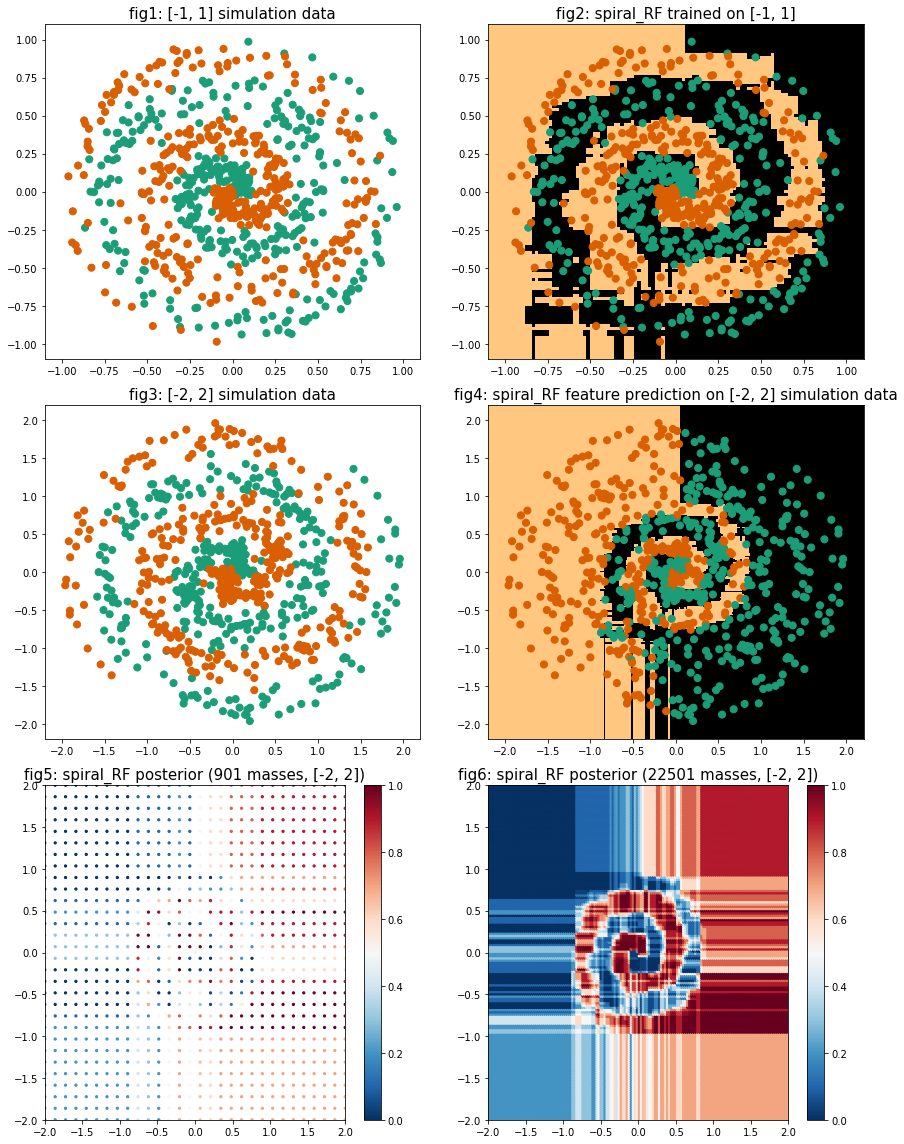

In [18]:
# enable = [0,0,0,0,0,1]
enable = [1,1,1,1,1,1]

train_algo(spirX, spirY, new_spirX, new_spirY, 1, enable)

## End of notebook